---
title: Facility Location
---

**Originally Contributed by**: Mathieu Tanneau and Alexis Montoison

In [1]:
using Random
using LinearAlgebra

using JuMP
import GLPK
using Plots

## Uncapacitated facility location

### Problem description

We are given
* $M=\{1, \dots, m\}$ clients
* $N=\{ 1, \dots, n\}$ sites where a facility can be built

**Decision variables**
Decision variables are split into two categories:
* Binary variable $y_{j}$ indicates whether facility $j$ is built or not
* Binary variable $x_{i, j}$ indicates whether client $i$ is assigned to facility $j$

**Objective**
The objective is to minimize the total cost of serving all clients.
This costs breaks down into two components:
* Fixed cost of building a facility.
In this example, this cost is $f_{j} = 1, \ \forall j$.
* Cost of serving clients from the assigned facility.
In this example, the cost $c_{i, j}$
of serving client $i$ from facility $j$
is the Euclidean distance between the two.

**Constraints**
* Each customer must be served by exactly one facility
* A facility cannot serve any client unless it is open

### MILP formulation

The problem can be formulated as the following MILP:

\begin{align}
\min_{x, y} \ \ \ &
\sum_{i, j} c_{i, j} x_{i, j} + 
\sum_{j} f_{j} y_{j}\\
s.t. &
\sum_{j} x_{i, j} = 1, && \forall i \in M\\
& x_{i, j} \leq y_{j}, && \forall i \in M, j \in N\\
& x_{i, j}, y_{j} \in \{0, 1\}, && \forall i \in M, j \in N
\end{align}

where the first set of constraints ensures
that each client is served exactly once,
and the second set of constraints ensures
that no client is served from an unopened facility.

### Problem data

In [2]:
Random.seed!(314)

m = 12  # number of clients
n = 5  # number of facility locations

# Clients' locations
Xc = rand(m)
Yc = rand(m)

# Facilities' potential locations
Xf = rand(n)
Yf = rand(n)

# Fixed costs
f = ones(n);

# Distance
c = zeros(m, n)
for i in 1:m
    for j in 1:n
        c[i, j] = norm([Xc[i] - Xf[j], Yc[i] - Yf[j]], 2)
    end
end

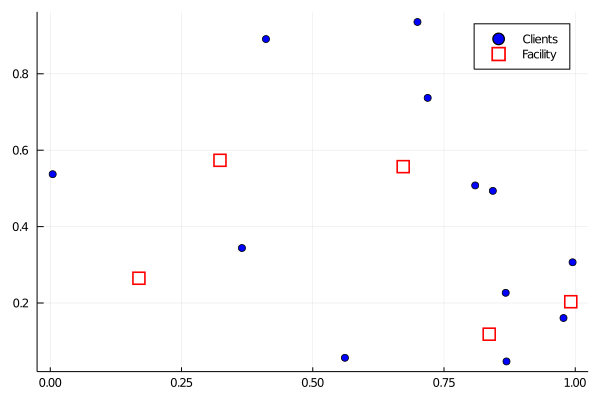

In [3]:
# Display the data
scatter(Xc, Yc, label = "Clients", markershape=:circle, markercolor=:blue)
scatter!(Xf, Yf, label="Facility", 
    markershape=:square, markercolor=:white, markersize=6,
    markerstrokecolor=:red, markerstrokewidth=2
)

### JuMP implementation

In [4]:
# Create a JuMP model
ufl = Model(GLPK.Optimizer)

# Variables
@variable(ufl, y[1:n], Bin);
@variable(ufl, x[1:m, 1:n], Bin);

# Each client is served exactly once
@constraint(ufl, client_service[i in 1:m],
    sum(x[i, j] for j in 1:n) == 1
);

# A facility must be open to serve a client
@constraint(ufl, open_facility[i in 1:m, j in 1:n],
    x[i, j] <= y[j]
)

# Objective
@objective(ufl, Min, f'y + sum(c .* x));

In [5]:
# Solve the uncapacitated facility location problem with GLPK
optimize!(ufl)
println("Optimal value: ", objective_value(ufl))

Optimal value: 5.226417970467934


### Visualizing the solution

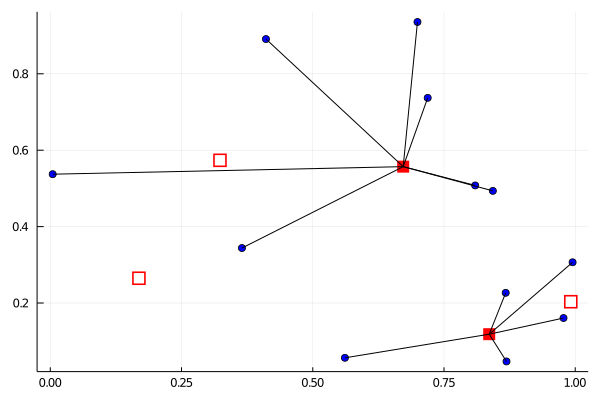

In [6]:
# The threshold 1e-5 ensure that edges between clients and facilities are drawn when x[i, j] ≈ 1.
x_ = value.(x) .> 1 - 1e-5
y_ = value.(y) .> 1 - 1e-5

# Display clients
p = scatter(Xc, Yc, markershape=:circle, markercolor=:blue, label=nothing)

# Show open facility
mc = [(y_[j] ? :red : :white) for j in 1:n]
scatter!(Xf, Yf, 
    markershape=:square, markercolor=mc, markersize=6,
    markerstrokecolor=:red, markerstrokewidth=2,
    label=nothing
)

# Show client-facility assignment
for i in 1:m
    for j in 1:n
        if x_[i, j] == 1
           plot!([Xc[i], Xf[j]], [Yc[i], Yf[j]], color=:black, label=nothing)
        end
    end
end

display(p)

## Capacitated Facility location

### Problem formulation

The capacitated variant introduces a capacity constraint on each facility, i.e., clients have a certain level of demand to be served, while each facility only has finite capacity which cannot be exceeded.

Specifically, let
* $a_{i} \geq 0$ denote the demand of client $i$
* $q_{j} \geq 0$ denote the capacity of facility $j$

The capacity constraints then write
\begin{align}
\sum_{i} a_{i} x_{i, j} &\leq q_{j} y_{j} && \forall j \in N
\end{align}

Note that, if $y_{j}$ is set to $0$, the capacity constraint above automatically forces $x_{i, j}$ to $0$.

Thus, the capacitated facility location can be formulated as follows

\begin{align}
\min_{x, y} \ \ \ &
\sum_{i, j} c_{i, j} x_{i, j} + 
\sum_{j} f_{j} y_{j}\\
s.t. &
\sum_{j} x_{i, j} = 1, && \forall i \in M\\
& \sum_{i} a_{i} x_{i, j} \leq q_{j} y_{j}, && \forall j \in N\\
& x_{i, j}, y_{j} \in \{0, 1\}, && \forall i \in M, j \in N
\end{align}

For simplicity, we will assume that there is enough capacity to serve the demand,
 i.e., there exists at least one feasible solution.

In [7]:
# Demands
a = rand(1:3, m);

# Capacities
q = rand(5:10, n);

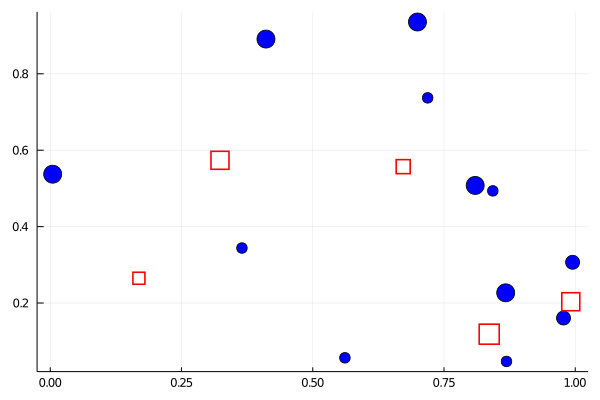

In [8]:
# Display the data
scatter(Xc, Yc, label=nothing,
    markershape=:circle, markercolor=:blue, markersize= 2 .*(2 .+ a)
)

scatter!(Xf, Yf, label=nothing, 
    markershape=:rect, markercolor=:white, markersize= q,
    markerstrokecolor=:red, markerstrokewidth=2
)

### JuMP implementation

In [9]:
# Create a JuMP model
cfl = Model(GLPK.Optimizer)

# Variables
@variable(cfl, y[1:n], Bin);
@variable(cfl, x[1:m, 1:n], Bin);

# Each client is served exactly once
@constraint(cfl, client_service[i in 1:m], sum(x[i, :]) == 1)

# Capacity constraint
@constraint(cfl, capacity, x'a .<= (q .* y))

# Objective
@objective(cfl, Min, f'y + sum(c .* x));

In [10]:
# Solve the problem
optimize!(cfl)
println("Optimal value: ", objective_value(cfl))

Optimal value: 5.836938427763575


### Visualizing the solution

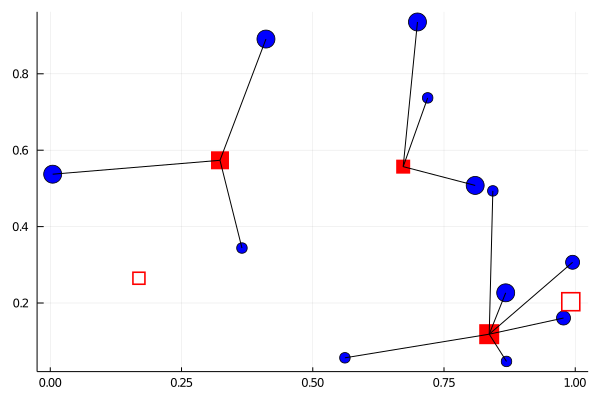

In [11]:
# The threshold 1e-5 ensure that edges between clients and facilities are drawn when x[i, j] ≈ 1.
x_ = value.(x) .> 1 - 1e-5
y_ = value.(y) .> 1 - 1e-5

# Display the solution
p = scatter(Xc, Yc, label=nothing,
    markershape=:circle, markercolor=:blue, markersize= 2 .*(2 .+ a)
)

mc = [(y_[j] ? :red : :white) for j in 1:n]
scatter!(Xf, Yf, label=nothing, 
    markershape=:rect, markercolor=mc, markersize=q,
    markerstrokecolor=:red, markerstrokewidth=2
)

# Show client-facility assignment
for i in 1:m
    for j in 1:n
        if x_[i, j] == 1
            plot!([Xc[i], Xf[j]], [Yc[i], Yf[j]], color=:black, label=nothing)
            break
        end
    end
end

display(p)

## Further
* [Benders decomposition](https://github.com/JuliaOpt/JuMPTutorials.jl/blob/master/script/optimization_concepts/benders_decomposition.jl)
is a method of choice for solving facility location problems.
* Benchmark instances can be found
[here](https://resources.mpi-inf.mpg.de/departments/d1/projects/benchmarks/UflLib/).